# Shelling's Agent-based model of Segregation
This is our week 12 workbook and will be available on Github from the powderflask/cap-comp215 repository.

An "Agent" is a persistent entity with properties and behaviours, that acts within the model.
In this model our Agents are very simple.  They have just 2 properties: a "type" (e.g., Red or Blue) and a location (e.g., they occupy a cell on the grid).
What makes this model different from the others we've examined is that these Agents can move far outside their neighbourhood.  Rather than think of the cell as have a state that changes, we think of each cell as containing an Agent (or being empty), and that Agent may move to another cell during the simulation.

Schelling's model and its rules are very well described on [wikipedia](https://en.wikipedia.org/wiki/Schelling%27s_model_of_segregation)

Credits:
    Original code examples from [Think Complexity, 2nd edition](https://thinkcomplex.com).
    Copyright 2016 Allen Downey, [MIT License](http://opensource.org/licenses/MIT)

As usual, the first code block just imports the modules we will use.

In [1]:
%matplotlib inline

import random
import time

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
from scipy.signal import correlate2d

# Configure matplotlib's animation library to work in the browser.
matplotlib.rc('animation', html='jshtml')

### Helpers
We're starting to collect some useful re-usable bits of code - we should consider putting these in an importable module...

In [2]:
# Define a colour map for black, red, blue.
cmap = [(0, 0, 0), (1, 0, 0), (0, 0, 1)]
shellings_colour_map = matplotlib.colors.ListedColormap(cmap)
DEFAULT_IMSHOW_OPTIONS = dict(
    cmap = shellings_colour_map,
    interpolation='none',
    origin='upper',
)

def plot_2D_array(array, axes=None, title='', **options):
    """ Plot the 2D array as an image on the given axes  1's will be dark blue, 0's will be light blue. """
    axes = axes or plt.gca()   # If not axes are provided, draw on current axes
    axes.set_title(title)
    axes.set_xticks([], [])  # remove axes tick marks
    axes.set_yticks([], [])
    options = {**DEFAULT_IMSHOW_OPTIONS, **options}
    axes.imshow(array, **options)

In [3]:
def legend(axes=None, **options):
    """Draws a legend only if there is at least one labeled data series.

    :param axes: the axes to add the legend to, or None to use the `plt.gca()` (current axes)
    :param options: keyword arguments passed directly to `plt.legend()`
           see https://matplotlib.org/api/_as_gen/matplotlib.pyplot.legend.html
    """
    options = { **dict(loc="best", frameon=False), **options}

    ax = axes or plt.gca()
    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend(handles, labels, **options)

In [4]:
class Animation2D:
    """
      Animates any 2D model with a step() method and a draw() method, using matplotlib
      model.step() should take no parameters - just step the model forward one step.
      model.draw() should take 2 parameters, the matpltolib axes to draw on and an integer step number

      See https://www.allendowney.com/blog/2019/07/25/matplotlib-animation-in-jupyter/
          for a discussion of the pros and cons of various animation techniques in jupyter notebooks
    """

    def __init__(self, model, frames=50, steps_per_frame=1, figsize=(8, 8)):
        """
        :param model: the simulation object to animate, with step() and draw(axes, step) methods
        :param frames: number of animation frames to generate
        """
        self.model = model
        self.frames = frames
        self.steps_per_frame = steps_per_frame
        self.fig, self.ax = plt.subplots(figsize=figsize)

    def animation_step(self, step):
        """ Step the model forward and draw the plot """
        if step > 0:
            for _ in range(self.steps_per_frame):
                self.model.step()
        self.model.draw(self.ax, step=step*self.steps_per_frame)

    def show(self):
        """ return the matplotlib animation object, ready for display """
        anim = animation.FuncAnimation(self.fig, self.animation_step, frames=self.frames)
        plt.close()  # this ensures the last frame is not shown as a separate plot
        return anim

    def animate(self, interval=None):
        """ Animate the model simulation directly in the notebook display block """
        from IPython.display import clear_output
        try:
            for i in range(self.frames):
                clear_output(wait=True)  # clear the IPython display
                self.ax.clear()          # clear old image from the axes (fixes a performance issue)
                plt.figure(self.fig)     # add the figure back to pyplot ** sigh **
                self.animation_step(i)
                plt.show()               # show the current animation frame (pyplot then closes and throws away figure ** sigh **)
                if interval:
                    time.sleep(interval)
        except KeyboardInterrupt:
            pass

## Schelling's model
Here's my refactored implementation of Alan Downey's Schelling model:

In [25]:
class Schelling:
    """A grid of Schelling agents and the rules to simulate Schelling's model with them."""
    
    # The "types" of Agent "living" in each cell.
    EMPTY = 0
    RED = 1
    BLUE = 2

    kernel = np.array([[1, 1, 1],
                       [1, 0, 1],
                       [1, 1, 1]], dtype=np.int8)
    
    def __init__(self, n, p, proportion_empty=0.1):
        """
        :param n: grid size:  n X n
        :param p: tolerance threshold - Agents with fraction of similar neighbors < p will move
        :param proportion_empty: the approx. proportion of the grid that are empty cells.
        """
        self.p = p
        
        proportion_per_agent_type = (1 - proportion_empty) / 2  # distribute remainder among agent types
        probs = [proportion_empty, proportion_per_agent_type, proportion_per_agent_type]
        self.state = np.random.choice([self.EMPTY, self.RED, self.BLUE], (n, n), p=probs)
   
    def occupied_neighbours_count(self, occupied):
        """ 
        Return int array, sized same as occupied, 
            with a count of number of occupied neighbours for occupied cells.
    
        :param occupied: a boolean or 0/1 valued array where 1 is considered "occupied"
        Only occupied cells will have a neighborhood count, empty cells have a count of zero.
        """
        neighbour_count = correlate2d(occupied, self.kernel, mode='same', boundary='wrap')
        # Zero out unoccupied cells so we only return neighbourhood counts for occupied cells
        return neighbour_count * occupied # Note: `*` with bool array is an 'and' operation
    
    def fraction_neighbours_similar(self):
        """
        Return float array, sized same as state, 
           with the fraction of neighbours that share a cell's value, or 0 for cells with no neighbours
        """
        num_red = self.occupied_neighbours_count(self.state == self.RED)
        num_blue = self.occupied_neighbours_count(self.state == self.BLUE)
        neighbour_count = self.occupied_neighbours_count(self.state != self.EMPTY)
        # ignore divide-by-zero during the division, then fix it up... 
        #   where the neighbour count is zero (e.g. empty cells), arbitrarily set the fraction to zero 
        with np.errstate(invalid='ignore'):
            fraction = (num_red + num_blue) / neighbour_count
            return np.where(neighbour_count==0, 0, fraction)
 
    def segregation(self):
        """ Return the average fraction of similar neighbors, averaged over entire grid. """
        return np.mean(self.fraction_neighbours_similar())
    
    def move_agents(self, agents):
        """ 
        Move all the given agents to empty cells in the grid, leaving their cells empty in return 
        
        :param agents: array, same shape as self.state, with agents that are looking for a new home
        """
        # Shuffle the moving agents and the empty cells into a single, randomized vector
        n_empty = np.sum(self.state == self.EMPTY) 
        n_red = np.sum(agents == self.RED)
        n_blue = np.sum(agents == self.BLUE)
        moving = np.concatenate((
            np.ones(n_empty) * self.EMPTY,
            np.ones(n_red) * self.RED,
            np.ones(n_blue) * self.BLUE
        ))
        np.random.shuffle(moving)
        
        # they all pack up and leave...
        self.state[agents!=self.EMPTY] = self.EMPTY  
        # ... and we assign them a new home
        self.state[self.state==self.EMPTY] = moving
 
    def step(self):
        """
        Execute one model time step.
                
        returns: current segregation value, i.e., the fraction of similar neighbors, averaged over entire grid
        """
        # boolean mask for unhappy agents, where the % similar neighbours is too low
        below_threshold = self.fraction_neighbours_similar() < self.p
 
        # mask out the unhappy agents and move them to empty cells
        unhappy_agents = self.state * below_threshold  # `*` with boolean acts like `and` operator
        self.move_agents(unhappy_agents)  
        
        # return the new segregation value (average fraction of similar neighbours)
        return self.segregation()
        
    def draw(self, axes=None, step=''):
        """Draws the cells on given axes."""
        axes = axes or plt.gca()  # use current axes if none are provided.
        plot_2D_array(self.state, axes,  title=f'Shelling @ step {step}')

Here's a small example.

0.47827380952380955

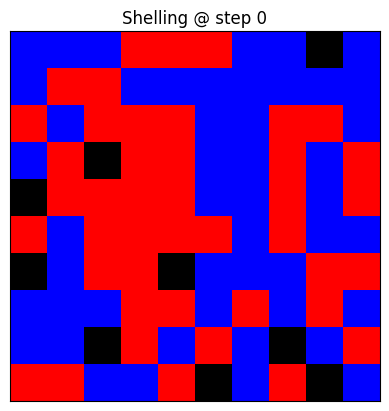

In [26]:
model = Schelling(n=10, p=0.3)
model.draw(step=0)
model.segregation()

And here's an animation for a bigger example.
The degree of segregation increases quickly.

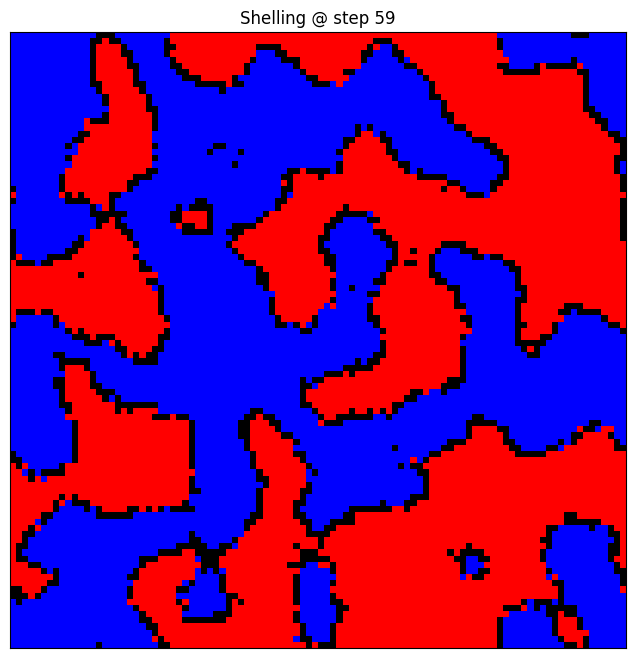

In [34]:
model = Schelling(n=100, p=0.7)
anim = Animation2D(model, frames=60)
anim.animate()

The following figure shows the process after a few steps.

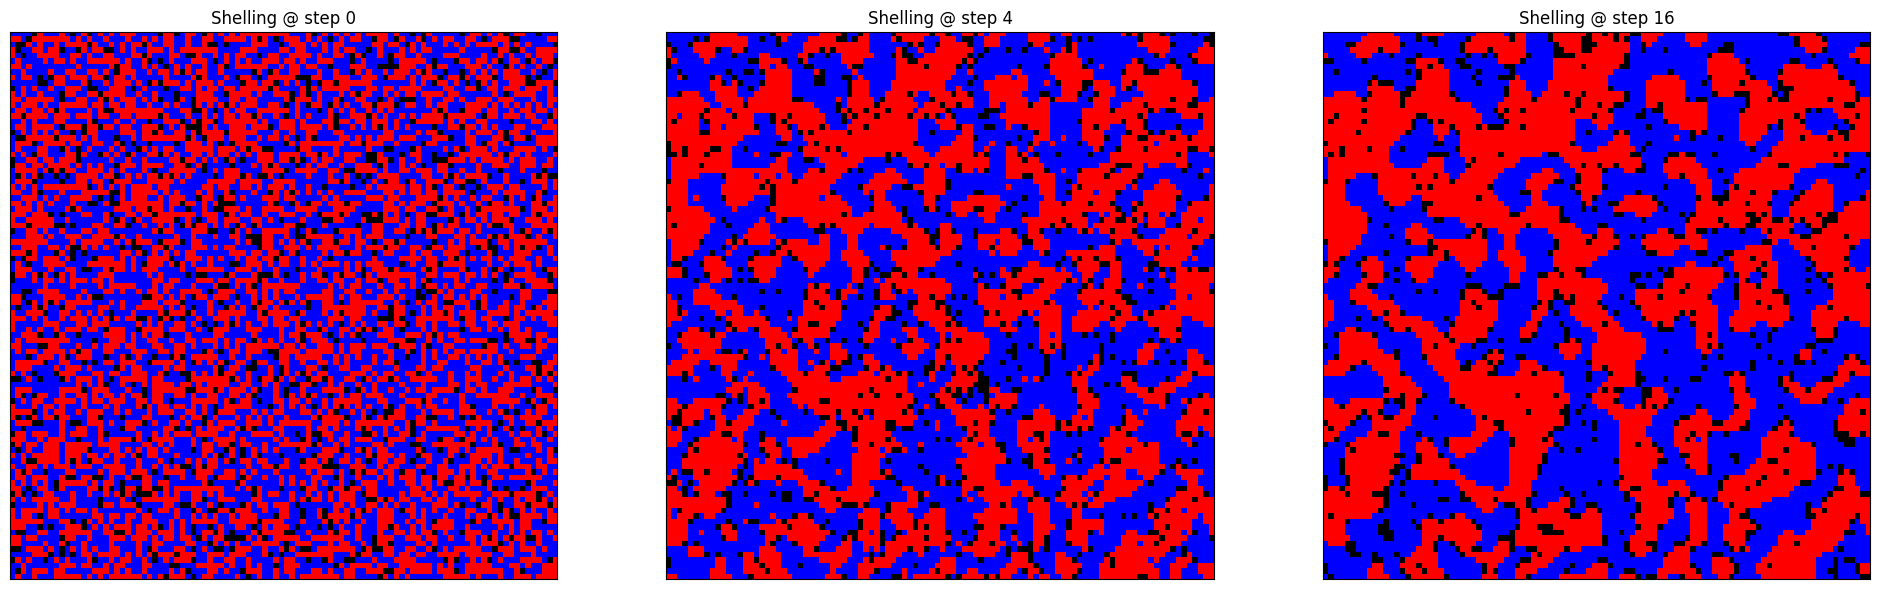

In [29]:
model = Schelling(n=100, p=0.5)

_, ax = plt.subplots(1, 3, figsize=(24, 8))
model.draw(ax[0], step=0) 

draw_at = (0, 4, 16)

for step in range(1, draw_at[-1]+1):
    model.step()
    if step in draw_at:
        model.draw(ax[draw_at.index(step)], step=step) 

And here's how segregation in steady state relates to `p`, the threshold on the fraction of similar neighbors.

0.5 0.7819261904761905
0.4 0.7376384523809524
0.3 0.6732294047619047
0.2 0.5192144047619048


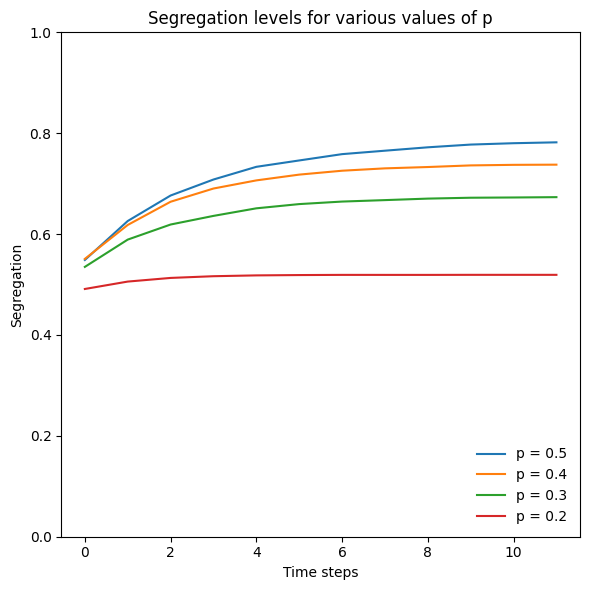

In [30]:
_, ax = plt.subplots(figsize=(6, 6), layout='tight') 
ax.set(
    title=f'Segregation levels for various values of p',
    xlabel='Time steps', 
    ylabel='Segregation',
    ylim=[0, 1]
)

for p in [0.5, 0.4, 0.3, 0.2]:
    model = Schelling(n=100, p=p)
    segregation_values = [model.step() for i in range(12)]
    ax.plot(segregation_values, label='p = %.1f' % p)
    print(p, segregation_values[-1])


legend(axes=ax, loc='lower right')
plt.show()

At `p=0.3`, there is a striking difference between the level that would make people happy, at only 30%, and the level they actually get, around 75%.

**Exercise:** Experiment with different starting conditions: for example, more or fewer empty cells, or unequal numbers of red and blue agents.